In [3]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal
import os
import random

import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import celluloid
from celluloid import Camera

import seaborn as sns


from franka.franka_utils import *

save = False

path = os.getcwd()
data_dir = "/home/ahalya/Documents/projects/mechanical-intelligence/data/rgb/data/"

rgb_dir = os.path.dirname(path) 
data_dir = os.path.dirname(rgb_dir) + "/data/rgb/data/"

print(data_dir)

/home/ahalya/Documents/projects/mechanical-intelligence/data/rgb/data/


In [4]:
dir_path1 = data_dir + "ergodic/"
# Load Pickled Data
file_path1 = dir_path1 + "data_eval_dict.pickle"
with open(file_path1, 'rb') as f: 
    data_dict1 = pickle.load(f, encoding="bytes")
    print(data_dict1.keys())
obj1 = data_dict1['obj_loc']
obj2 = data_dict1['obj2_loc']
traj1 = data_dict1['path']
loss1 = data_dict1['losses']
buffer1 = data_dict1['buffer']
action1 = data_dict1['actions']
env_traj1 = data_dict1['env_path']
env_lim = data_dict1['tray_lim']
klerg_lim = data_dict1['klerg_lim']

print(traj1.shape)
print(len(buffer1), np.array(buffer1[0][0]).shape, traj1[0])

dict_keys(['path', 'actions', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'losses', 'tray_lim', 'klerg_lim'])
(1000, 4)
1000 (2,) [-0.7815724   0.74329734  0.2        -0.2       ]


In [5]:

# Load Pytorch Models
# model1 = torch.load("model_int_check.pth")
device = torch.device('cpu')
model1 = torch.load(dir_path1 + "model_final_postlearning.pth", map_location=device)
model1.eval()


/home/ahalya/python-envs/sensory-learning/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'vae.vae.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ahalya/python-envs/sensory-learning/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ahalya/python-envs/sensory-learning/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1))
    (3): Flatten()
  )
  (encode): Sequential(
    (0): Linear(in_features=5122, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
  )
  (img_decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(5, 5, kernel_size=(5, 5), stride=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(5, 3, kernel_size=(5, 5), stride=(2, 2))
  )
  (imgvar_decoder): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
  (img_decode): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Line

Done Plotting


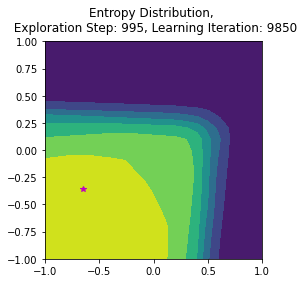

In [6]:
traj_ind = 0
learning_ind = 0
img_num = 0
batch_size = 10
z_dim = 16
# fig, ax = plt.subplots()
fig = plt.figure()
fig.patch.set_facecolor('white')

camera = Camera(fig)

for traj_ind in range(len(traj1)):
    traj_ind += 1
    if batch_size < traj_ind < len(traj1):
        learning_ind += 10
        if learning_ind % 50 == 0: 
            with torch.no_grad():
                PATH =  dir_path1 + "model_checkpoint_iter"+str(learning_ind)+".pth"
                model1.load_state_dict(torch.load(PATH, map_location=device)['state_dict'])
                model1.eval()
                xd = np.expand_dims(np.array(buffer1[traj_ind][0]), axis=0)
                xd = torch.FloatTensor(xd)
                yd = np.expand_dims(np.array(buffer1[traj_ind][1]), axis=0)
                yd = torch.FloatTensor(yd)
#                 print(xd.shape,yd.shape)
                
                _, _ , z_mu, z_logvar, _ = model1(xd,yd)
                z_samples = model1.reparameterize(z_mu, z_logvar)

                x, y = np.meshgrid(np.linspace(-1.,1.,21), 
                                       np.linspace(-1.,1.,21))
                samples = np.c_[x.ravel(), y.ravel()]
                logexp_data = [None]*len(samples)
                for i in range(len(samples)):
                    xr = np.expand_dims(samples[i], 0)
                    xr = torch.FloatTensor(xr)
                    z_samples = z_samples.repeat(xr.shape[0], 1)
                    y_logvar = model1.imgvar_decoder(torch.cat([z_samples, xr], dim=1))
                    logexp_data[i] = y_logvar.exp().detach().numpy().squeeze()       
                data = np.reshape(logexp_data, (21,21))
                data_norm = np.reshape((logexp_data/np.max(logexp_data)), (21,21))
#                 clear_output()
                plt.cla()
                fig.patch.set_facecolor('white')
                plt.contourf(x, y, data)
#                 plt.plot(traj1[:traj_ind, 0],traj1[:traj_ind, 1], 'k')
                plt.plot(traj1[traj_ind,0], traj1[traj_ind,1], 'm*')
                plt.title("Entropy Distribution, \n Exploration Step: {}, Learning Iteration: {}".format(traj_ind, learning_ind), pad=10)
#                 plt.colorbar()
                plt.axis('square')
#                 plt.savefig('results/rgb/klerg_entropy_evol/' + str("{:03d}".format(img_num)) +'_rgb_entropy_evol'+'.png')
#                 plt.savefig('results/rgb/klerg_entropy_evol/' + str("{:03d}".format(img_num)) +'_rgb_entropy_evol_withtraj'+'.png')
                if save: plt.savefig('results/rgb/klerg_entropy_evol/' + str("{:03d}".format(img_num)) +'_rgb_entropy_evol_withloc'+'.png')

    #                 plt.show()
                img_num += 1

print("Done Plotting")
        
        


(75, 75, 3)